In [13]:
import json
import pandas as pd
import os
import numpy as np

In [16]:
with open('../diag_jsons/Dead-Poets-Society_script.json') as f:
    story = json.load(f)

In [17]:
from nltk.stem import *
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# setup a new hash to store the results in
def script_cleaning(script):
    processed_article_hash = {}
    #porter_stemmer = PorterStemmer()
    lemmatizer = WordNetLemmatizer() 
    stop_words = set(stopwords.words('english'))
    # iterate through the keys, i.e. document ids, in the hash to pull out the stored text and process
    for key in script.keys():
        text_of_article = script[key]
        word_tokens = word_tokenize(text_of_article)
        words = [word for word in word_tokens if word.isalpha()]
        words = [str.lower(w) for w in words if not str.lower(w) in stop_words]
        processed_article_hash[key] = [lemmatizer.lemmatize(word) for word in words]
    return processed_article_hash

In [18]:
import numpy as np
def jacardian_distance(document_1_data, document_2_data):
    words_in_doc_1_not_in_doc_2 = list(set(document_1_data) - set(document_2_data))
    words_in_doc_2_not_in_doc_1 = list(set(document_2_data) - set(document_1_data))
    words_in_both_doc_1_and_doc_2 = list(set.intersection(*[set(document_1_data), set(document_2_data)]))
    
    jacardian = len(words_in_both_doc_1_and_doc_2)/(len(words_in_doc_1_not_in_doc_2)+
                                                    len(words_in_doc_2_not_in_doc_1)+
                                                    len(words_in_both_doc_1_and_doc_2))# divide the counts appropiately
    
    return jacardian

def cosine_similarity(document_1_data, document_2_data):
    document_vector_word_index = list(set.union(set(document_1_data),set(document_2_data))) # here fill this with an ordered list of all the unique words across both documents
    document_1_vector = np.array([document_1_data.count(word) for word in document_vector_word_index]) # fill in the array with the frequency of the words in the document
    document_2_vector = np.array([document_2_data.count(word) for word in document_vector_word_index]) # fill in the array with the frequency of the words in the document
    dot_product_of_two_document_vectors = document_1_vector.dot(document_2_vector)/(np.sqrt(np.dot(document_1_vector,document_1_vector)) * np.sqrt(np.dot(document_2_vector,document_2_vector)))
    return dot_product_of_two_document_vectors # you can refer to the numpy information on how to calculate the dot product of vectors

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
# create a variable to store your table data... you could use a hash or some other data structure. 
# We just want it to identify which document is being compared to which other document.
def prep_data_structs(processed_article_hash):
    data_structure_for_jacard_similarity = {}#
    data_structure_for_cosine_similarity = {}#

    for doc_1_key in processed_article_hash.keys():
        data_structure_for_jacard_similarity[doc_1_key] = {}
        data_structure_for_cosine_similarity[doc_1_key] = {}
        for doc_2_key in processed_article_hash.keys():
            # we have the nested for loops as one way to compare each document to each other document
            data_structure_for_jacard_similarity[doc_1_key][doc_2_key] = jacardian_distance(processed_article_hash[doc_1_key], 
                                                                                            processed_article_hash[doc_2_key])
            data_structure_for_cosine_similarity[doc_1_key][doc_2_key] = cosine_similarity(processed_article_hash[doc_1_key], processed_article_hash[doc_2_key])
    return data_structure_for_jacard_similarity, data_structure_for_cosine_similarity
# finally, find some way to present this data back. Either as a straight table or a heatmap.
def create_heatmap(data_dict):
    temp = pd.DataFrame(data_dict)
    temp = temp.sort_index()[temp.sort_index().index]
    
    article_row = [str(each) for each in temp.index]
    article_col = [str(each) for each in temp.columns]

    data = temp.values
    fig, ax = plt.subplots(figsize=(12,12))
    im = ax.imshow(data)

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(article_col)))
    ax.set_yticks(np.arange(len(article_row)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(article_col)
    ax.set_yticklabels(article_row)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(article_row)):
        for j in range(len(article_col)):
            text = ax.text(j, i, round(data[i, j],2),
                           ha="center", va="center", color="w")

    ax.set_title("Similarity Heatmap")
    fig.tight_layout()
    plt.show()

In [21]:
with open('../diag_jsons/Dead-Poets-Society_script.json') as f:
    story = json.load(f)

processed_data = script_cleaning(story['dialogues'])
data_structs_c = prep_data_structs(processed_data)
temp = [data_structs_c[k] for k in data_structs_c.keys()]
mean_similarity.appnd(np.mean(temp))

#print(k, sum(data_structs_c[k].values()), np.std(list(data_structs_c[k].values())), len(set(processed_data[k])))

AttributeError: 'tuple' object has no attribute 'keys'

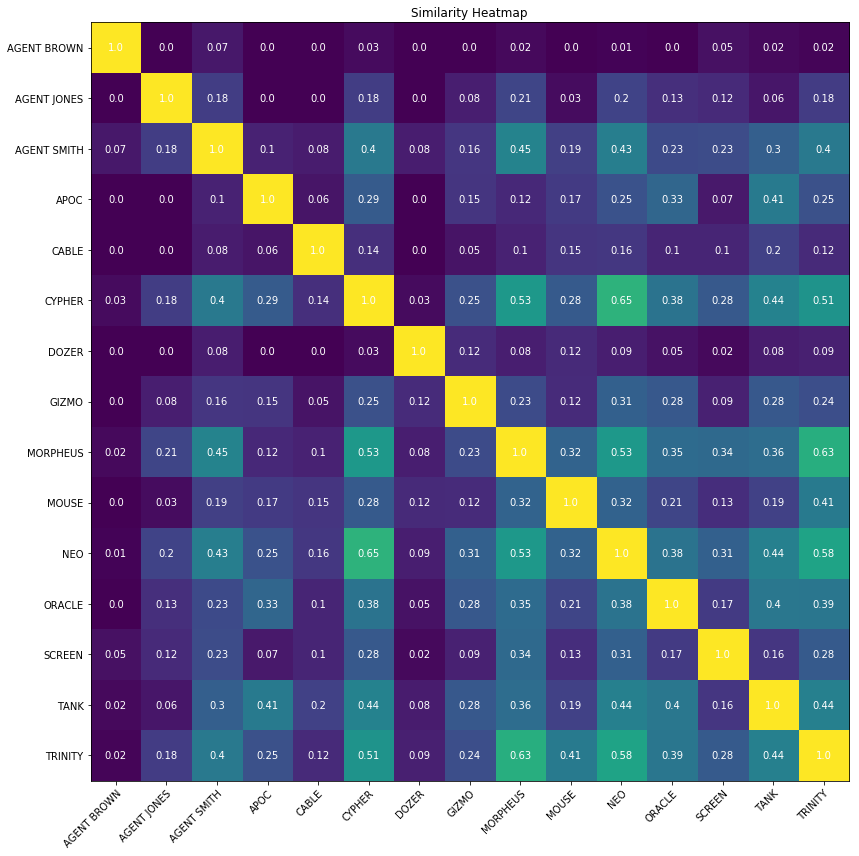

NEO 5.643203024502513 0.23970882073034538 246
MORPHEUS 5.2592333099904085 0.24597302918884895 460
TRINITY 5.531449546586105 0.24199923594429976 199
AGENT SMITH 4.2849788512618305 0.23083861483116244 287
TANK 4.773458774570512 0.23005041937567483 180
CYPHER 5.389481776499648 0.24309700768245177 207
GIZMO 3.3642587778885913 0.2251904684419542 52
ORACLE 4.403816913479885 0.2271203676527717 73
AGENT JONES 2.381283598338417 0.23759505240084974 28
APOC 3.1864541008529375 0.2436187924270011 13
MOUSE 3.6492633419092 0.2277354383147746 22
AGENT BROWN 1.2122570265910808 0.24641053735391735 12
SCREEN 3.359557760179074 0.2284214124000201 56
DOZER 1.7605210963209867 0.23964097891161856 11
CABLE 2.2540263809302576 0.2344084391131282 15


In [24]:
with open('../diag_jsons/Matrix,-The_script.json') as f:
    story = json.load(f)

processed_data = script_cleaning(story['dialogues'])
data_structs_j, data_structs_c = prep_data_structs(processed_data)
create_heatmap(data_structs_c)
#create_heatmap(data_structs_j)
for k in data_structs_c.keys():
    print(k, sum(data_structs_c[k].values()), np.std(list(data_structs_c[k].values())), len(set(processed_data[k])))

In [9]:
with open('Indiana-Jones-and-the-Temple-of-Doom_script.json') as f:
    story = json.load(f)

processed_data = script_cleaning(story['dialogues'])
data_structs_j, data_structs_c = prep_data_structs(processed_data)
#create_heatmap(data_structs_c)
#create_heatmap(data_structs_j)
for k in data_structs_c.keys():
    print(k, sum(data_structs_c[k].values()), np.std(list(data_structs_c[k].values())), len(set(processed_data[k])))

INDIANA 2.925704549160656 0.27527275823115915 593
WILLIE 3.1022257572357503 0.2738923714690337 386
SHORT ROUND 1.9593718006668235 0.3198393470480051 136
CHATTAR LAL 2.3947724434206132 0.27292709430860534 161
LAO 1.984761214370947 0.3007090545166056 43
MOLA RAM 1.9988767739663618 0.2907239358784528 72
MAHARAJAH 2.1265517425237634 0.2830271902890434 68
SHAMAN 2.0527455510641173 0.29671035301941806 49


In [10]:
with open('Shawshank-Redemption,-The_script.json') as f:
    story = json.load(f)

processed_data = script_cleaning(story['dialogues'])
data_structs_j, data_structs_c = prep_data_structs(processed_data)
#create_heatmap(data_structs_c)
#create_heatmap(data_structs_j)
for k in data_structs_c.keys():
    print(k, sum(data_structs_c[k].values()), np.std(list(data_structs_c[k].values())), len(set(processed_data[k])))

RED 5.363662332771118 0.23648591573735847 973
ANDY 5.002264781135497 0.2459950527208025 628
NORTON 4.8041832895401395 0.23836073514155867 356
HEYWOOD 4.542109221321405 0.22424701734870925 186
HADLEY 4.5728359125164735 0.21131617525597685 189
BROOKS 4.119083688838406 0.239573833812448 219
TOMMY 4.418295624929571 0.23251212915044617 157
FLOYD 2.631345905856876 0.23578352158700114 44
BOGS 2.867453952944398 0.23508433692972247 52
VOICE 1.3999211375289493 0.2510827252494794 15
SNOOZE 3.506759902153036 0.22709693656338684 25
GUARD 2.077734591854184 0.24031056093079597 21
JIGGER 3.009562358619279 0.22940361021826666 21
HAIG 2.8051084709796728 0.2312043550296021 21


In [11]:
with open('Departed,-The_script.json') as f:
    story = json.load(f)

processed_data = script_cleaning(story['dialogues'])
data_structs_j, data_structs_c = prep_data_structs(processed_data)
#create_heatmap(data_structs_c)
#create_heatmap(data_structs_j)
for k in data_structs_c.keys():
    print(k, sum(data_structs_c[k].values()), np.std(list(data_structs_c[k].values())), len(set(processed_data[k])))

COLIN 7.489506993077247 0.199803858711933 532
BILLY 8.24340686580522 0.17543250503524876 494
COSTELLO 7.358684980331508 0.1970240005338749 482
MADOLYN 5.350708067284642 0.20904295732514003 222
QUEENAN 5.976914411747699 0.20781494741600878 248
ELLERBY 6.346910127503907 0.20776358431534891 282
DIGNAM 6.112070626623671 0.19197149904863997 185
MISTER FRENCH 6.182231892197827 0.19360183562509184 132
BROWN 4.034620785462869 0.21326583457464882 73
DELAHUNT 5.553701067588109 0.1911385211821531 76
FITZY 5.0411949026083045 0.20229531770830544 59
SEAN 4.493532644143483 0.20262556398523537 90
YOUNG COSTELLO 3.9205965707443156 0.21603274901799305 71
DETECTIVE 1 4.379925439840374 0.20944194173981312 31
BARRIGAN 4.670121747437632 0.20025165515423776 38
BANKROBBER 3.813685596487633 0.21226630973120608 26


In [13]:
with open('John-Wick_script.json') as f:
    story = json.load(f)

processed_data = script_cleaning(story['dialogues'])
data_structs_j, data_structs_c = prep_data_structs(processed_data)
#create_heatmap(data_structs_c)
#create_heatmap(data_structs_j)
for k in data_structs_c.keys():
    print(k, sum(data_structs_c[k].values()), np.std(list(data_structs_c[k].values())), len(set(processed_data[k])))

JOHN 4.713708270525782 0.1976218444307212 227
VIGGO 4.912649858322166 0.1990259766088584 195
IOSEF 3.51780442908033 0.22664439965651456 57
AURELIO 4.4031958092365135 0.20765389486425784 45
MANAGER 3.3048531186716414 0.26057193735152673 58
WAITRESS 3.1140849070892394 0.26478745007431864 21
CAPTAIN 2.950061336806725 0.2191558932377404 32
MARCUS 4.042232293007286 0.22434541459482674 74
HARRY 4.413165122291295 0.24851339037037737 26
VIKTOR 2.812274379151498 0.23416884707174576 28
EDWARDO 3.46725439817502 0.2278626813105147 44
CHARLIE 4.000871888667173 0.2518701945473562 37
JENNY 2.6561951644328383 0.22636821578402522 30
JIMMY 3.8771157805157253 0.24276025696229905 20
BANK MANAGER 1.8860229615871291 0.24158349352241612 5
EDDIE 2.249099916781039 0.23000381885945975 10


In [15]:
with open('Wolf-of-Wall-Street,-The_script.json') as f:
    story = json.load(f)

processed_data = script_cleaning(story['dialogues'])
data_structs_j, data_structs_c = prep_data_structs(processed_data)
#create_heatmap(data_structs_c)
#create_heatmap(data_structs_j)
for k in data_structs_c.keys():
    print(k, sum(data_structs_c[k].values()), np.std(list(data_structs_c[k].values())), len(set(processed_data[k])))

JORDAN 7.737368620566339 0.19367404295659255 1477
DONNIE 6.180322370977525 0.20237925536677015 291
NAOMI 5.402352301658026 0.19813534443600644 207
AGENT DENHAM 4.308255125616418 0.1948103688198134 125
TERESA 4.5798295507525735 0.19601574501432853 55
AUNT EMMA 3.72653910463981 0.19464654407763363 62
MAX 4.09784870799753 0.20692733331507054 80
BRAD 3.604241401915729 0.19975221121151998 53
BO DIETL 4.7062671289473 0.19656291591819847 92
SAUREL 3.3124262195981253 0.19329198618581217 115
MARK HANNA 4.945603129369456 0.19954630645323737 136
JORDAN  (CONT'D) 4.795907067225681 0.1945248018747822 102
SEA OTTER 3.917100678867187 0.19501143118097594 39
STEVE MADDEN 2.506547065147964 0.19904919173324082 52
RUGRAT 2.4691689987839855 0.1996281367782609 28
GENE HACKMAN 1.21884150769059 0.20696076533739766 19
JERRY FOGEL 3.7470869893867906 0.20214439341642976 34
DWAYNE 3.228153079864293 0.19886777640057832 54
CHESTER MING 3.2503499101417836 0.19490574866114882 27
JANET 2.2893351244290714 0.20336032709

In [17]:
with open('How-to-Train-Your-Dragon-2_script.json') as f:
    story = json.load(f)

processed_data = script_cleaning(story['dialogues'])
data_structs_j, data_structs_c = prep_data_structs(processed_data)
#create_heatmap(data_structs_c)
#create_heatmap(data_structs_j)
for k in data_structs_c.keys():
    print(k, sum(data_structs_c[k].values()), np.std(list(data_structs_c[k].values())), len(set(processed_data[k])))

HICCUP 4.981710506036841 0.20795574842536127 457
STOICK 4.483731055516061 0.22250188189607745 226
VALKA 4.67898571402542 0.22368359353188003 232
ASTRID 4.189342420675554 0.2203174168130256 144
ERET 4.344440863489888 0.2276038839406494 166
DRAGO 3.9099432528016553 0.24000232950532957 93
GOBBER 3.2869439779245595 0.23542587153745714 166
RUFFNUT 3.033708305593434 0.23550098630051775 46
FISHLEGS 3.0282447404375157 0.2336490467310706 45
TUFFNUT 3.2436644741119225 0.2281556897532403 49
SNOTLOUT 2.5016563980603 0.24670943021879682 40


In [8]:
with open('../diag_jsons/127-Hours_script.json') as f:
    story = json.load(f)

processed_data = script_cleaning(story['dialogues'])
data_structs_j, data_structs_c = prep_data_structs(processed_data)
#create_heatmap(data_structs_c)
#create_heatmap(data_structs_j)
for k in data_structs_c.keys():
    print(k, sum(data_structs_c[k].values()), np.std(list(data_structs_c[k].values())), len(set(processed_data[k])))

ARON 2.1807532394278946 0.29022850326685157 583
MEGAN 2.01357840697229 0.31389882258593993 73
KRISTI 2.075711396955252 0.30477099767544913 57
RANA 1.8548098087194285 0.32965571932080956 51
ERIK 1.4154002068887586 0.3608964189143739 54


In [12]:
print(story['dialogues']['ARON'])


[1]Nearly missed it! 
[2]Hey. Are you doing the east pike? Can I come along with you for a while? 
[3]I'm on my own. I'm Aron. 
[4]Nice to meet you. What a day. 
[5]Did you bike or come straight from the trail head? 
[6]I left mine at the Horseshoe Canyon and biked here. 7. 
[7]17 and windy. 
[8]I do this a lot. 
[9]Wasn't expecting to see anyone in the canyon today. 
[10]Sorry. 
[11]Yeah, I know, I mean there's no one around for 50 miles. 
[12]Let me guess... You're here for the paintings or the Cathedral? 
[13]The climb's a little tricky but it's worth it. 
[14]There's thousands of holds but you can't see them until you're almost upside down and then they just keep appearing... it's a bit of a act of faith so I'll go first... take off as much as you dare as there's a bit of a surprise at the other end... 
[15]I swear I won't look but I swear you won't care when you get out here... 
[16]... and the thing is, when you get to the middle... 
[17]... there aren't any more. 
[18]Well, the